手动实现超参数搜索，使用房价预测数据集,实战超参数为学习率

缺点：
    使用for循环实现；且无法并行化搜索

In [1]:
# 使用tf.keras搭建回归模型，数据集使用加利福尼亚的房价预测
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# 导入数据
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
# 打印数据
import pprint

pprint.pprint(housing.data[:5])
pprint.pprint(housing.target[:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
# 拆分训练集、测试集、验证集
from sklearn.model_selection import train_test_split

# 默认按3：1的比例拆分
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 数据归一化

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 训练机上获得均值和方差，测试集和验证集上用相同的均值和方差
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 构建模型

In [10]:
#learning_rate:[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
# W = W + grad * learning_rate

learning_rate = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for lr in learning_rate:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation='relu', input_shape=x_train.shape[1:]),
        #最后一层一个神经元
        keras.layers.Dense(1),
    ])
    # 定义优化器，使用自主学习率
    optimizer = keras.optimizers.SGD(lr)
    # 编译，目标函数使用均方差，优化方法使用随机梯度下降，也可以自己定义
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # 使用earlystopping
    callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
    history = model.fit(x_train_scaled, y_train,
                   validation_data = (x_valid_scaled, y_valid),
                   epochs=100, callbacks=callbacks)
    histories.append(history)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 34us/sample - loss: 5.6568 - val_loss: 4.9293
Epoch 2/100
11610/11610 [==============================] - 0s 24us/sample - loss: 4.0217 - val_loss: 3.6328
Epoch 3/100
11610/11610 [==============================] - 0s 25us/sample - loss: 3.0193 - val_loss: 2.8080
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 2.3720 - val_loss: 2.2638
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.9352 - val_loss: 1.8847
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: 1.6283 - val_loss: 1.6145
Epoch 7/100
11610/11610 [==============================] - 0s 26us/sample - loss: 1.4093 - val_loss: 1.4190
Epoch 8/100
11610/11610 [==============================] - 0s 24us/sample - loss: 1.2485 - val_loss: 1.2730
Epoch 9/100
11610/11610 [==============================] - 0s 23us/sample - loss: 1.128

Epoch 76/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5553 - val_loss: 0.6040
Epoch 77/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5539 - val_loss: 0.6024
Epoch 78/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5525 - val_loss: 0.6008
Epoch 79/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5511 - val_loss: 0.5993
Epoch 80/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5498 - val_loss: 0.5978
Epoch 81/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5485 - val_loss: 0.5963
Epoch 82/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5472 - val_loss: 0.5949
Epoch 83/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5459 - val_loss: 0.5935
Epoch 84/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5447 - val_loss: 0.5921
Epoch 85/100
11610/

11610/11610 [==============================] - 0s 24us/sample - loss: 0.4994 - val_loss: 0.5321
Epoch 51/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4979 - val_loss: 0.5316
Epoch 52/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4964 - val_loss: 0.5294
Epoch 53/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4950 - val_loss: 0.5279
Epoch 54/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4936 - val_loss: 0.5264
Epoch 55/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4922 - val_loss: 0.5250
Epoch 56/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4908 - val_loss: 0.5223
Epoch 57/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4897 - val_loss: 0.5206
Epoch 58/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4885 - val_loss: 0.5195
Epoch 59/100
11610/11610 [======

11610/11610 [==============================] - 0s 33us/sample - loss: 0.4501 - val_loss: 0.4791
Epoch 25/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4473 - val_loss: 0.4777
Epoch 26/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4443 - val_loss: 0.4723
Epoch 27/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4420 - val_loss: 0.4698
Epoch 28/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4394 - val_loss: 0.4668
Epoch 29/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4372 - val_loss: 0.4646
Epoch 30/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4349 - val_loss: 0.4622
Epoch 31/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4331 - val_loss: 0.4596
Epoch 32/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4310 - val_loss: 0.4577
Epoch 33/100
11610/11610 [======

11610/11610 [==============================] - 0s 27us/sample - loss: 0.3725 - val_loss: 0.3924
Epoch 100/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.3720 - val_loss: 0.3921
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 1.5542 - val_loss: 0.7685
Epoch 2/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.7422 - val_loss: 0.6356
Epoch 3/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5629 - val_loss: 0.5786
Epoch 4/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5202 - val_loss: 0.5499
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4898 - val_loss: 0.5100
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4746 - val_loss: 0.4938
Epoch 7/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4600 - val_lo

11610/11610 [==============================] - 0s 32us/sample - loss: 0.3625 - val_loss: 0.3705
Epoch 23/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3610 - val_loss: 0.3686
Epoch 24/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.3558 - val_loss: 0.3666
Epoch 25/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3542 - val_loss: 0.3687
Epoch 26/100
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3552 - val_loss: 0.3642
Epoch 27/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.3531 - val_loss: 0.3792
Epoch 28/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4266 - val_loss: 0.3650
Epoch 29/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.3555 - val_loss: 0.3624
Epoch 30/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3546 - val_loss: 0.3647
Epoch 31/100
11610/11610 [======

D:\SoftWare\Anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1224: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


11610/11610 [==============================] - 0s 29us/sample - loss: nan - val_loss: nan
Epoch 4/100
11610/11610 [==============================] - 0s 28us/sample - loss: nan - val_loss: nan
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: nan - val_loss: nan
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: nan - val_loss: nan


Learning_rate: 0.0001


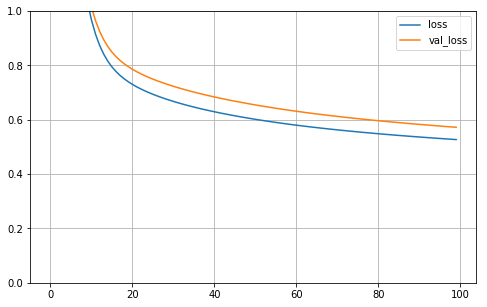

Learning_rate: 0.0003


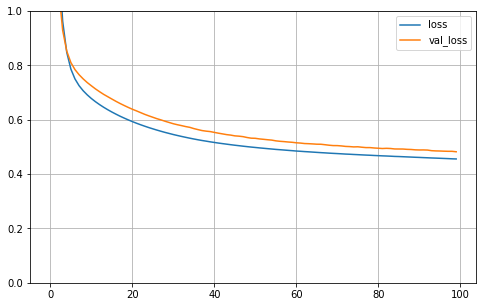

Learning_rate: 0.001


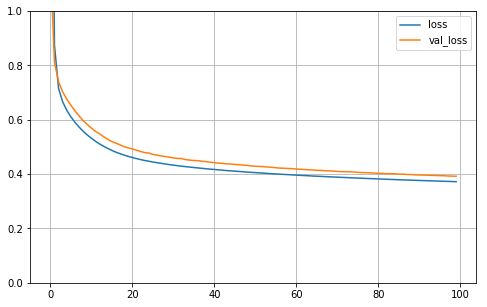

Learning_rate: 0.003


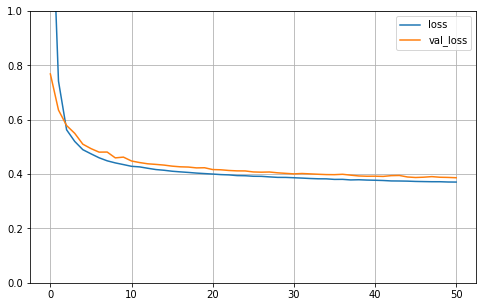

Learning_rate: 0.01


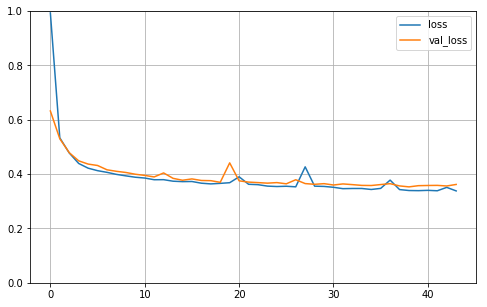

Learning_rate: 0.03


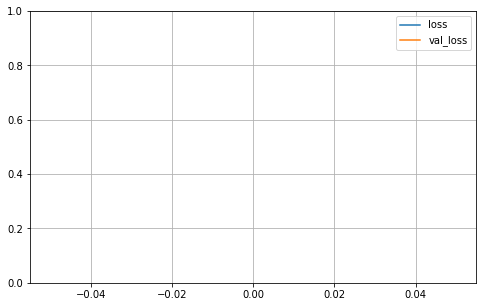

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

for lr, history in zip(learning_rate, histories):
    print("Learning_rate:", lr)
    plot_learning_curves(history)